In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors as pcolors
from IPython.display import HTML, Image
import base64
from scipy import stats
from enum import IntEnum
import os
import joblib
import subprocess
import itertools
import warnings 

%matplotlib inline

warnings.simplefilter('ignore')

if not os.path.exists('plots'): os.mkdir('plots')

# We encoded white and black berserk data in one column in the csv to save space
class BerserkSide(IntEnum):
    NEITHER = 0
    WHITE = 1
    BLACK = 2
    BOTH = 3
# Same deal with Termination, we used int instead of string
class Termination(IntEnum):
    NORMAL = 0
    TIME_FORFEIT = 1

class Streak(IntEnum):
    ZERO = 0
    ONE = 1
    TWO_PLUS = 2
    def __str__(self):
        return '2+' if self.value == self.TWO_PLUS else f'{self.value}'

class Color(IntEnum):
    WHITE = 0
    BLACK = 1
    def __str__(self):
        return 'white' if self.value == self.WHITE else 'black'
    def opposite(self):
        return 'black' if self.value == Color.WHITE else 'white'

class Result(IntEnum):
    LOSS_OR_DRAW = 0
    WIN = 1

class Action(IntEnum):
    NO_BERSERK = 0
    BERSERK = 1

streaks = np.array([Streak.ZERO, Streak.ONE, Streak.TWO_PLUS])
colors = np.array([Color.WHITE, Color.BLACK])
results = np.array([Result.LOSS_OR_DRAW, Result.WIN])
actions = np.array([Action.NO_BERSERK, Action.BERSERK])

plt.rcParams.update({
  'text.usetex': True,
  'font.family': 'Palatino',
  'figure.facecolor': 'white',
  'figure.dpi': 100,
  'figure.figsize': (10, 10),
  'savefig.bbox': 'tight'
})

In [2]:
# Outside this notebook, we combined all csvs into one using csvkit:
# $ csvstack *.csv  > all.csv
games = pd.read_csv(
    '../lichess_games/all.csv', 
    usecols=[
        'white_rating', 
        'black_rating', 
        'time', 
        'berserk', 
        'result'
    ],
    dtype={ # np.ushort = uint16, np.ubyte = uint8
        'white_rating': np.ushort, 
        'black_rating': np.ushort, 
        'time': np.ubyte, 
        'berserk': np.ubyte, 
        'result': np.ubyte
    }
)

games['white_berserked'] = (games['berserk'] == BerserkSide.WHITE) | (games['berserk'] == BerserkSide.BOTH)
games['black_berserked'] = (games['berserk'] == BerserkSide.BLACK) | (games['berserk'] == BerserkSide.BOTH)
games['white_berserked'] = games['white_berserked'].astype(np.ubyte)
games['black_berserked'] = games['black_berserked'].astype(np.ubyte)
games.drop(columns=['berserk'], inplace=True) 

time = 1 # the time control time+0 we are interested in, where time is in minutes. the data has only 1+0 and 3+0 games
games = games[(games['time'] == time)] 
games.reset_index(inplace=True, drop=True)
games.drop(columns=['time'], inplace=True) 

min_rating = 600 # n.b. lichess doesn't let ratings go below 600
max_rating = 3200 if time == 1 else 3000 # there are too few games where either player had a higher rating
ratings = np.arange(min_rating, max_rating + 1)
bin_width = 100
rating_bins = np.arange(min_rating, max_rating + 1, bin_width)

games = games[
    (games['white_rating'] >= min_rating) & (games['white_rating'] < max_rating) &
    (games['black_rating'] >= min_rating) & (games['black_rating'] < max_rating) 
]

In [3]:
HTML(f'<h1>When should you berserk in a {time}+0 lichess arena tournament game?</h1>')

Your goal in a lichess arena is to accumulate the most points possible. A win gives 2 points, a draw 1, and a loss 0. However, if you are on a win streak of 2 or more games, then you earn double points (so that a win gives 4 points and a draw 2) until you fail to win a game. Additionally, at the start of any game, you can choose to berserk: you cut the time on your clock in half, but if you win you get an extra point. (See the [lichess arena FAQ](https://lichess.org/tournament/help?system=arena) for details.) Of course, having less time should generally make winning more difficult. So the question arises: what policy should one follow to maximize their points in an arena tournament given this unique payoff structure? For example, you might think to play more conservatively and rarely berserk, focusing on prolonging win streaks to get double points as often as possible. Or you might attempt to play as aggressively as possible and berserk often, reasoning that the extra points you get from berserk game wins will outweigh the double points you'll lose out on when you do end up losing win streaks. I've attempted to give a rudimentary answer to this question here.

I considered only 1+0 and 3+0 tournaments for this analysis, which are the standard time controls for Bullet and SuperBlitz arenas, as well as for the monthly lichess Titled Arena and Blitz Titled Arena. 

In [4]:
HTML(f'This document considers arena tournament games with time control {time}+0.')

## The data
Refer to this repo's README for some information on how and what data I collected. In short, I looked at all relevant lichess arena tournament games from 2017-2021. First, we attempt to answer the question of this document using only the empirical data. 

In [5]:
all_ratings = pd.concat([games['white_rating'], games['black_rating']])
all_berserk_ratings = pd.concat([
    games['white_rating'][games['white_berserked'] == 1], 
    games['black_rating'][games['black_berserked'] == 1]
    ])

high = 2800
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
axs[0].hist(all_ratings, bins=rating_bins)
axs[0].set_title('rating occurrences')
axs[0].ticklabel_format(axis='y', style='plain', scilimits=(0,0))
axs[1].hist(all_ratings[(all_ratings >= high)], bins=rating_bins[rating_bins >= high])
axs[1].set_title(fr'$\geq {high}$ rating occurrences')
axs[1].set_xticks(rating_bins[rating_bins >= high])
axs[1].ticklabel_format(axis='y', style='plain', scilimits=(0,0))
axs[2].hist(all_berserk_ratings, bins=rating_bins)

axs[2].ticklabel_format(axis='y', style='plain', scilimits=(0,0))
axs[2].set_title('rating berserk occurrences')
axs[3].hist(all_berserk_ratings[(all_berserk_ratings >= high)], bins=rating_bins[rating_bins >= high])
axs[3].set_title(fr'$\geq {high}$ rating berserk occurrences')
axs[3].set_xticks(rating_bins[rating_bins >= high])
axs[3].ticklabel_format(axis='y', style='plain', scilimits=(0,0))
fig.text(0.5, -0.01, 'rating', ha='center', va='center')
fig.text(0.0, 0.5, 'count', ha='center', va='center', rotation='vertical')
fig.tight_layout()
plt.savefig(f'plots/{time}_rating_berserk_occurrences.png')
plt.close(fig) # not immediately germane to the main question, so we save the plot but don't export it in the notebook

In [6]:
a = pd.DataFrame({
    'rating': pd.concat([games['white_rating'], games['black_rating']]),
    'berserked': pd.concat([games['white_berserked'], games['black_berserked']])
    })

b = np.array(a['berserked'].groupby(pd.cut(a['rating'], rating_bins)).apply(lambda x: [len(x), sum(x)]).tolist())

n, _ = np.histogram(all_ratings, rating_bins)
nb, _ = np.histogram(all_berserk_ratings, rating_bins)

ci = 99
ci_lower_p = 0.5 - ci / 200
ci_upper_p = 0.5 + ci / 200
# equal-tailed ci% credible interval assuming betabinomial distribution https://stats.stackexchange.com/a/238582
# this is a simplistic assumption, not really accurate, 
# but it's a quick way to get a rough idea of the spread
ci_lower = stats.betabinom.ppf(ci_lower_p, b[:,0], b[:,1] + 1, b[:,0] - b[:,1] + 1) / b[:,0]
ci_upper = stats.betabinom.ppf(ci_upper_p, b[:,0], b[:,1] + 1, b[:,0] - b[:,1] + 1) / b[:,0]

fig = plt.figure(figsize=(10, 5))
plt.bar(rating_bins[:-1], nb / n, width=bin_width, yerr=[nb / n - ci_lower, ci_upper - nb / n], 
    align='edge', alpha=0.5, ecolor='black', capsize=3)

plt.grid('both', which='both')
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', grid_alpha=0)
plt.xlim(min_rating, max_rating)
plt.ylabel('berserk probability')
plt.xlabel('rating')
plt.savefig(f'plots/{time}_berserk_probability.png')
plt.close(fig) # not immediately germane to the main question, so we save the plot but don't export it in the notebook

In [7]:
del a, b, all_ratings, all_berserk_ratings

In [8]:
rating_interval_range_freq = 100
rating_interval_range = pd.interval_range(start=min_rating, end=max_rating, closed='left', freq=rating_interval_range_freq)

In [9]:
# convert vector s of canonical scores (0 for black win, 1 for draw, 2 for white win) to means
# e.g. v = [3,1,0] means a black win is 3 points, a draw is 1 point and a white win is 0 points
score2value = lambda v, s: (
    np.dot([0.5, -1, 0.5], v) * s**2 + 
    np.dot([-1.5, 2, -0.5], v) * s +
    np.dot([1, 0, 0], v)
) 

white_no_streak_mean = lambda scores: np.mean(score2value([0,1,2], scores))
white_no_streak_sem = lambda scores: stats.sem(score2value([0,1,2], scores))
white_streak_mean = lambda scores: np.mean(score2value([0,2,4], scores))
white_streak_sem = lambda scores: stats.sem(score2value([0,2,4], scores))
black_no_streak_mean = lambda scores: np.mean(score2value([2,1,0], scores))
black_no_streak_sem = lambda scores: stats.sem(score2value([2,1,0], scores))
black_streak_mean = lambda scores: np.mean(score2value([4,2,0], scores))
black_streak_sem = lambda scores: stats.sem(score2value([4,2,0], scores))

g = games[(games['white_berserked'] == 0) & (games['black_berserked'] == 0)]
h = (
    g
    .groupby([
        pd.cut(g['white_rating'], rating_interval_range),
        pd.cut(g['black_rating'], rating_interval_range)
    ])
    .agg(
        n=('result', np.size),
        white_no_streak_mean=('result', white_no_streak_mean),
        white_no_streak_sem=('result', white_no_streak_sem),
        white_streak_mean=('result', white_streak_mean),
        white_streak_sem=('result', white_streak_sem),
        black_no_streak_mean=('result', black_no_streak_mean),
        black_no_streak_sem=('result', black_no_streak_sem),
        black_streak_mean=('result', black_streak_mean),
        black_streak_sem=('result', black_streak_sem)
    )
    .reset_index()
)
h['white_mid'] = h['white_rating'].apply(lambda x: x.mid)
h['black_mid'] = h['black_rating'].apply(lambda x: x.mid)

white_berserk_no_streak_mean = lambda scores: np.mean(score2value([0,1,3], scores))
white_berserk_no_streak_sem = lambda scores: stats.sem(score2value([0,1,3], scores))
white_berserk_streak_mean = lambda scores: np.mean(score2value([0,2,5], scores))
white_berserk_streak_sem = lambda scores: stats.sem(score2value([0,2,5], scores))
black_berserk_no_streak_mean = lambda scores: np.mean(score2value([3,1,0], scores))
black_berserk_no_streak_sem = lambda scores: stats.sem(score2value([3,1,0], scores))
black_berserk_streak_mean = lambda scores: np.mean(score2value([5,2,0], scores))
black_berserk_streak_sem = lambda scores: stats.sem(score2value([5,2,0], scores))

g = games[(games['white_berserked'] == 1) & (games['black_berserked'] == 0)]
h_white_berserk = (
    g
    .groupby([
        pd.cut(g['white_rating'], rating_interval_range),
        pd.cut(g['black_rating'], rating_interval_range)
    ])
    .agg(
        n=('result', np.size), 
        no_streak_mean=('result', white_berserk_no_streak_mean),
        no_streak_sem=('result', white_berserk_no_streak_sem),
        streak_mean=('result', white_berserk_streak_mean),
        streak_sem=('result', white_berserk_streak_sem)
    )
    .reset_index()
)
h_white_berserk['white_mid'] = h_white_berserk['white_rating'].apply(lambda x: x.mid)
h_white_berserk['black_mid'] = h_white_berserk['black_rating'].apply(lambda x: x.mid)

g = games[(games['white_berserked'] == 0) & (games['black_berserked'] == 1)]
h_black_berserk = (
    g
    .groupby([
        pd.cut(g['white_rating'], rating_interval_range),
        pd.cut(g['black_rating'], rating_interval_range)
    ])
    .agg(
        n=('result', np.size), 
        no_streak_mean=('result', black_berserk_no_streak_mean),
        no_streak_sem=('result', black_berserk_no_streak_sem),
        streak_mean=('result', black_berserk_streak_mean),
        streak_sem=('result', black_berserk_streak_sem)
    )
    .reset_index()
)
h_black_berserk['white_mid'] = h_black_berserk['white_rating'].apply(lambda x: x.mid)
h_black_berserk['black_mid'] = h_black_berserk['black_rating'].apply(lambda x: x.mid)
    

### Empirical expected value of berserking vs. not berserking
We first look at the relative frequencies of wins, draws, and losses (WDL) when a player berserks vs. when they do not berserk, for each matchup of player rating and opponent rating (looking only at games where the opponent does not berserk). Using the empirical relative frequencies as WDL probability estimates, we can multiply them by the respective points the player would earn in each result, and thereby get empirical expected values for both berserking and not berserking. For example, for a certain opponent rating matchup, a player's empirical WDL when not berserking might be `[0.5, 0.05, 0.45]`. Assuming they are not on a streak, their point payoffs for win, draw, and loss would be `[2, 1, 0]`. Then the expected value would be `0.5 * 2 + 0.05 * 1 + 0.45 * 0 = 1.05`. The player's empirical WDL when berserking might be `[0.35, 0.05, 0.6]`, while the point payoffs for win, draw, and loss would be `[3, 1, 0]`, so that the expected value would be `0.35 * 3 + 0.05 * 1 + 0.6 * 0 = 1.1`. So based on these empirical WDL probability estimates, it would be better to berserk in this case, since the expected value for berserking is greater than the expected value for not berserking. On the other hand, if the player is on a 2+ win streak, then the expected values for not berserking and berserking would be `0.5 * 4 + 0.05 * 2 + 0.45 * 0 = 2.1` and `0.35 * 5 + 0.05 * 2 + 0.6 * 0 = 1.85`, respectively. In this case, it would be better not to berserk, since the expected value for not berserking is greater than the expected value for berserking. 

This is what I have done in this plot. The color of the square in each rating matchup reflects the difference of the expected value of berserking and not berserking; the redder the color, the better it is for the player to berserk their opponent, and the bluer the color, the better it is not to berserk. The size of each square corresponds to the number of games in each rating matchup in which one player berserked. I clamped the colormap to 1 and -1 so that outlier values with a very small amount of games did not cause the colormap to lose resolution. 

As one might expect, the lower your opponent's rating compared to yours, the better it is to berserk. Also, it seems that if your opponent's rating is near yours, berserking is less promising, and this is compounded if you are on a streak. If your opponent's rating is much greater than yours, the picture is less clear: the differences in expected value are generally much slighter.

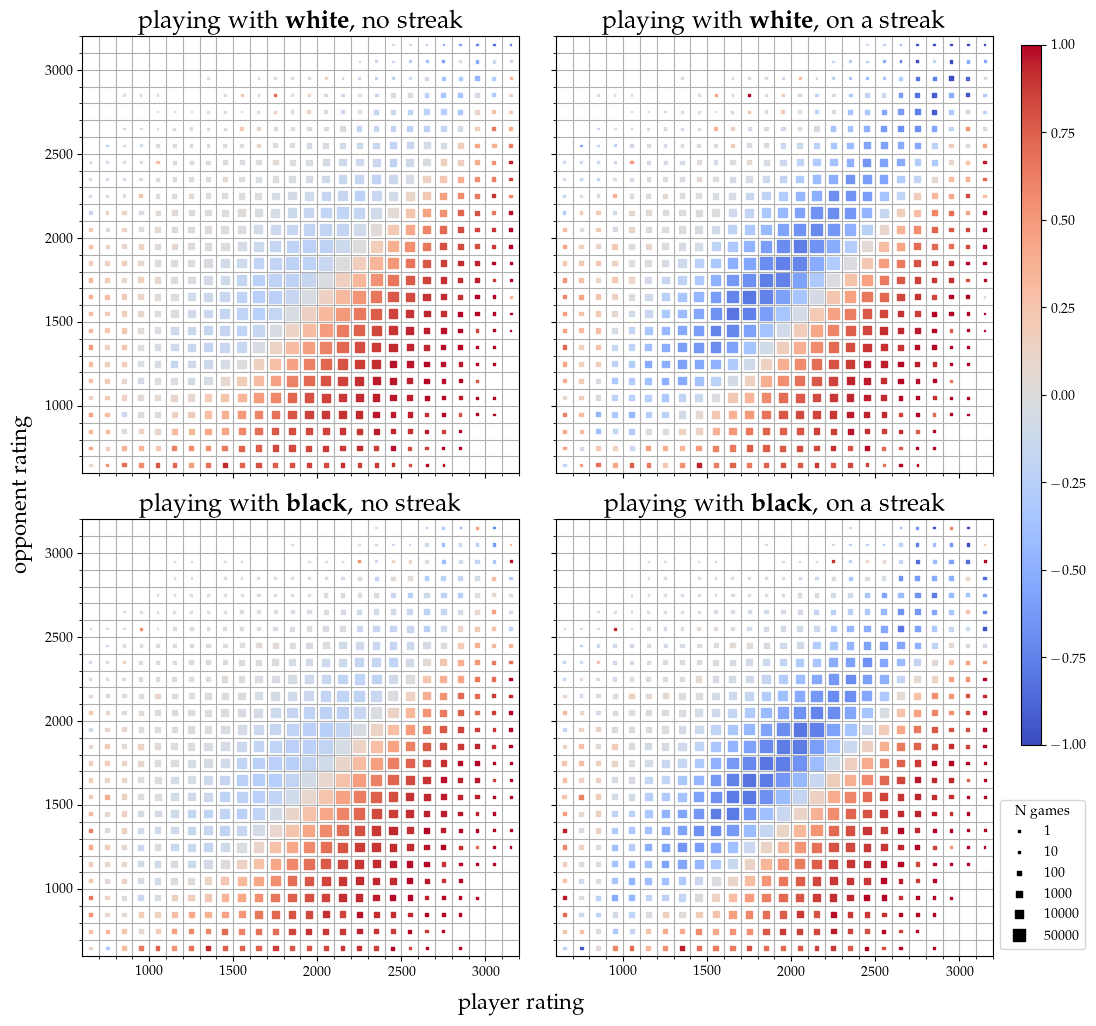

In [10]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs = axs.flatten()

titles = [
    r'playing with \textbf{white}, no streak', 
    r'playing with \textbf{white}, on a streak', 
    r'playing with \textbf{black}, no streak', 
    r'playing with \textbf{black}, on a streak'
]

white_berserk_sched = [1,1,0,0]
black_berserk_sched = [0,0,1,1]
h_sched = ['white_no_streak_mean', 'white_streak_mean', 'black_no_streak_mean', 'black_streak_mean']
hb_sched = ['no_streak_mean', 'streak_mean', 'no_streak_mean', 'streak_mean']

nscale = lambda n: np.power(n, 0.4)

# some points will be <-1 or >1 but they will be colored as if they are -1 or 1 to retain 
# a reasonable amount of detail in the colormap, as we are mostly interested in the sign of each value
vmin = -1
vmax = 1

for i, ax in enumerate(axs):

    x = h['white_mid'] if white_berserk_sched[i] else h['black_mid']
    y = h['black_mid'] if white_berserk_sched[i] else h['white_mid']
    hb = h_white_berserk if white_berserk_sched[i] else h_black_berserk
    diff = hb[hb_sched[i]] - h[h_sched[i]]
    s = ax.scatter(
        x=x, 
        y=y, 
        c=diff, 
        s=np.nan_to_num(nscale(hb['n'])),
        marker='s',
        vmin=vmin, vmax=vmax, 
        cmap=plt.cm.coolwarm
    )

    ax.set_xlim(min_rating, max_rating)
    ax.set_ylim(min_rating, max_rating)
    ax.set_aspect('equal')
    ax.grid('both', which='both')
    ax.minorticks_on()
    ax.set_title(titles[i], fontsize=18)

fig.text(0.5, -0.01, 'player rating', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.5, 'opponent rating', ha='center', va='center', rotation='vertical', fontsize=16)
fig.tight_layout()

sizes = np.array([1, 10, 100, 1000, 10000, 50000])
handles, labels = s.legend_elements(prop='sizes', num=nscale(sizes))
labels = sizes.astype(int)
legend = ax.legend(handles, labels, bbox_to_anchor=(1.0, 0.0), loc='lower left', title="N games")

cb_ax = fig.add_axes([1.0, 0.25, 0.02, 0.7])
cbar = fig.colorbar(s, cax=cb_ax)

plt.savefig(f'plots/{time}_empirical_berserk_expected_value_difference.png')

### Policy for berserking vs. not berserking based on empirical expected values
Taking the calculations from the previous plot, we can generate a simple policy: if the empirical expected value for berserking is greater than the empirical expected value for not berserking, then berserk; otherwise, don't berserk. This plot and others like it below should be interpreted with caution as the degree to which it is better or worse to berserk is lost here. Also, the noise due to the paucity of games in which a player berserked for some rating matchups is more evident here. 

In [11]:
cmap2 = plt.cm.get_cmap('Paired', 2)
bounds = [-1e9, 1e-9, 1e9]
norm = pcolors.BoundaryNorm(bounds, cmap2.N)

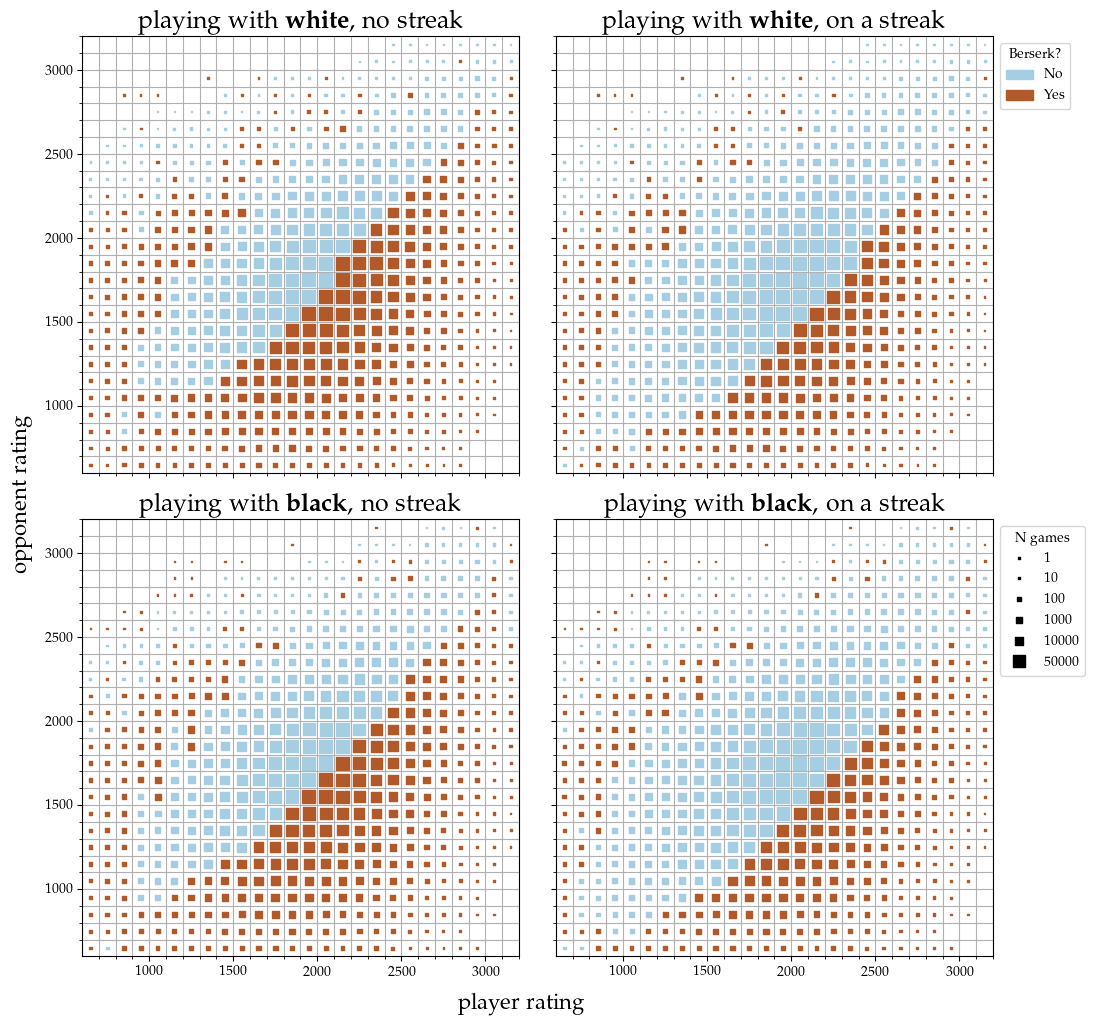

In [12]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
axs = axs.flatten()

titles = [
    r'playing with \textbf{white}, no streak', 
    r'playing with \textbf{white}, on a streak', 
    r'playing with \textbf{black}, no streak', 
    r'playing with \textbf{black}, on a streak'
]

white_berserk_sched = [1,1,0,0]
black_berserk_sched = [0,0,1,1]
h_sched = ['white_no_streak_mean', 'white_streak_mean', 'black_no_streak_mean', 'black_streak_mean']
hb_sched = ['no_streak_mean', 'streak_mean', 'no_streak_mean', 'streak_mean']

for i, ax in enumerate(axs):

    x = h['white_mid'] if white_berserk_sched[i] else h['black_mid']
    y = h['black_mid'] if white_berserk_sched[i] else h['white_mid']
    hb = h_white_berserk if white_berserk_sched[i] else h_black_berserk
    diff = hb[hb_sched[i]] - h[h_sched[i]]
    diff = np.sign(diff)
    s = ax.scatter(
        x=x, 
        y=y, 
        c=np.nan_to_num(diff), 
        s=np.nan_to_num(nscale(hb['n'])),
        marker='s',
        cmap=cmap2
    )

    ax.set_xlim(min_rating, max_rating)
    ax.set_ylim(min_rating, max_rating)
    ax.set_aspect('equal')
    ax.grid('both', which='both')
    ax.minorticks_on()
    ax.set_title(titles[i], fontsize=18)

fig.text(0.5, -0.01, 'player rating', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.5, 'opponent rating', ha='center', va='center', rotation='vertical', fontsize=16)
fig.tight_layout()

labels = ['No', 'Yes']
legend_color = axs[1].legend([patches.Patch(color=cmap2(i)) for i in [0, 1]], labels, bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Berserk?')

sizes = np.array([1, 10, 100, 1000, 10000, 50000])
handles, labels = s.legend_elements(prop='sizes', num=nscale(sizes))
labels = sizes.astype(int)
legend = ax.legend(handles, labels, bbox_to_anchor=(1.0, 1.0), loc='upper left', title="N games")

plt.savefig(f'plots/{time}_empirical_berserk_expected_value_better.png', dpi = 300, bbox_inches = 'tight', facecolor = 'white')

In [13]:
wdl_model = joblib.load(f'pickles/{time}_wdl_model_search.pkl')

t = pd.DataFrame(
    np.array([[w,b,wb,bb] 
        for w in ratings 
        for b in ratings 
        for wb in range(0,2) 
        for bb in range(0,2)]
    ),
    columns=['white_rating','black_rating','white_berserked','black_berserked']
)
wdl_probs = wdl_model.predict_proba(t)


## Modeling the data
I fit a series of models on different aspects of the data, with an eye to generating a more informed policy for berserking than the one described above. This more detailed policy is shown in the final section of this notebook.
### Modeling WDL probabilities 
I fit a logistic regression model to the data to predict the WDL probabilities for every combination of `(white rating, black rating, white berserked, black berserked)`. The fitting was done in `wdl_model_search.py`. Using the same calculations as described above, one can take these model WDL probabilities and using them to generate model expected values for (not) berserking in different scenarios. Here we see that the model expected values generally agree well with empirical expected values. The only deficiency seems to be some trouble predicting the empirical expected value curves at the lowest player rating levels.  

In [14]:
titles = [
    r'you have \textbf{white}, no streak', 
    r'you have \textbf{white}, on a streak', 
    r'you have \textbf{black}, no streak', 
    r'you have \textbf{black}, on a streak'
]

white_berserk_sched = [1,1,0,0]
black_berserk_sched = [0,0,1,1]
h_sched = ['white_no_streak_mean', 'white_streak_mean', 'black_no_streak_mean', 'black_streak_mean']
h_sem_sched = ['white_no_streak_sem', 'white_streak_sem', 'black_no_streak_sem', 'black_streak_sem']
hb_sched = ['no_streak_mean', 'streak_mean', 'no_streak_mean', 'streak_mean']
hb_sem_sched = ['no_streak_sem', 'streak_sem', 'no_streak_sem', 'streak_sem']

wb = [1,1,0,0]
bb = [0,0,1,1]
va = [[0,1,2], [0,2,4], [2,1,0], [4,2,0]]
vb = [[0,1,3], [0,2,5], [3,1,0], [5,2,0]]
side = ['white_rating', 'white_rating', 'black_rating', 'black_rating']

legend_axis = 1

for interval in rating_interval_range:
    r = interval.mid
    rl = interval.left
    rr = interval.right
    
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        c = h['white_mid'] if white_berserk_sched[i] else h['black_mid']
        hr = h[c == r]
        hb = h_white_berserk if white_berserk_sched[i] else h_black_berserk
        hbr = hb[c == r]

        x = hr['black_mid'] if white_berserk_sched[i] else hr['white_mid']
        x = x.to_numpy()

        # ax.plot(x, hr[h_sched[i]], '_', color='b', alpha=0.3, markersize=12)
        ax.fill_between( # these dummy concats are needed to get the first fill_between to show up
            np.concatenate(([0], x + rating_interval_range_freq / 2)), 
            np.concatenate(([0], hr[h_sched[i]] - 2*hr[h_sem_sched[i]])), 
            np.concatenate(([0], hr[h_sched[i]] + 2*hr[h_sem_sched[i]])), 
            color = 'b', alpha=0.2, step='pre', label=r'observed ±2 SEM: \textbf{not berserking}'
        )
        # ax.plot(x, hbr[hb_sched[i]], '_', color='r', alpha=0.3, markersize=12)
        ax.fill_between(
            np.concatenate(([0], x + rating_interval_range_freq / 2)), 
            np.concatenate(([0], hbr[hb_sched[i]] - 2*hbr[hb_sem_sched[i]])), 
            np.concatenate(([0], hbr[hb_sched[i]] + 2*hbr[hb_sem_sched[i]])), 
            color='r', alpha=0.2, step='pre', label=r'observed ±2 SEM: \textbf{berserking}'
        )

        a = wdl_probs[(t['white_berserked'] == 0) & (t['black_berserked'] == 0) & (t[side[i]] == r)]
        b = wdl_probs[(t['white_berserked'] == wb[i]) & (t['black_berserked'] == bb[i]) & (t[side[i]] == r)]
        ea = np.dot(a, va[i])
        eb = np.dot(b, vb[i])

        ax.plot(ratings, ea, '-', color='b', label=r'predicted: \textbf{not berserking}')
        ax.plot(ratings, eb, '-', color='r', label=r'predicted: \textbf{berserking}')

        ax.fill_between(
            [rl, rr], 
            [0, 0], 
            [5, 5], 
            color='black', alpha=0.1, step='pre', label='your rating'
        )

        ax.set_xlim(min_rating, max_rating)
        ax.set_ylim(0, 5)
        ax.grid('both', which='both')
        ax.minorticks_on()
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_title(titles[i], fontsize=18)

        if i == legend_axis: legend = ax.legend(loc='best', fontsize=12)

    ls = r'\phantom{0}' if rl < 1000 else ''
    rs = r'\phantom{0}' if rr < 1000 else ''
    fig.suptitle(fr'your rating is between {ls}{rl} and {rs}{rr}', fontsize=20)
    fig.text(0.5, -0.01, 'opponent rating', ha='center', va='center', fontsize=16)
    fig.text(-0.01, 0.5, 'expected value', ha='center', va='center', rotation='vertical', fontsize=16)
    fig.tight_layout()

    plt.savefig(f'plots/{time}_expected_value_curves_{rl:04}_{rr:04}.png')
    plt.close(fig)

In [15]:
subprocess.call([   
    'ffmpeg',
    '-hide_banner', 
    '-loglevel', 'error',
    '-f', 'image2',
    '-pattern_type', 'glob',
    '-framerate', '2', 
    '-i', f'plots/{time}_expected_value_curves_*.png', 
    f'plots/{time}_expected_value_curves.mp4', 
    '-y'
]);

In [16]:
# https://gif.ski/
subprocess.call([
    'gifski',
    '--quiet',
    '--fps', '2',
    '--width', '1000',
    '-o', f'plots/{time}_expected_value_curves.gif', 
    f'plots/{time}_expected_value_curves.mp4'
]);


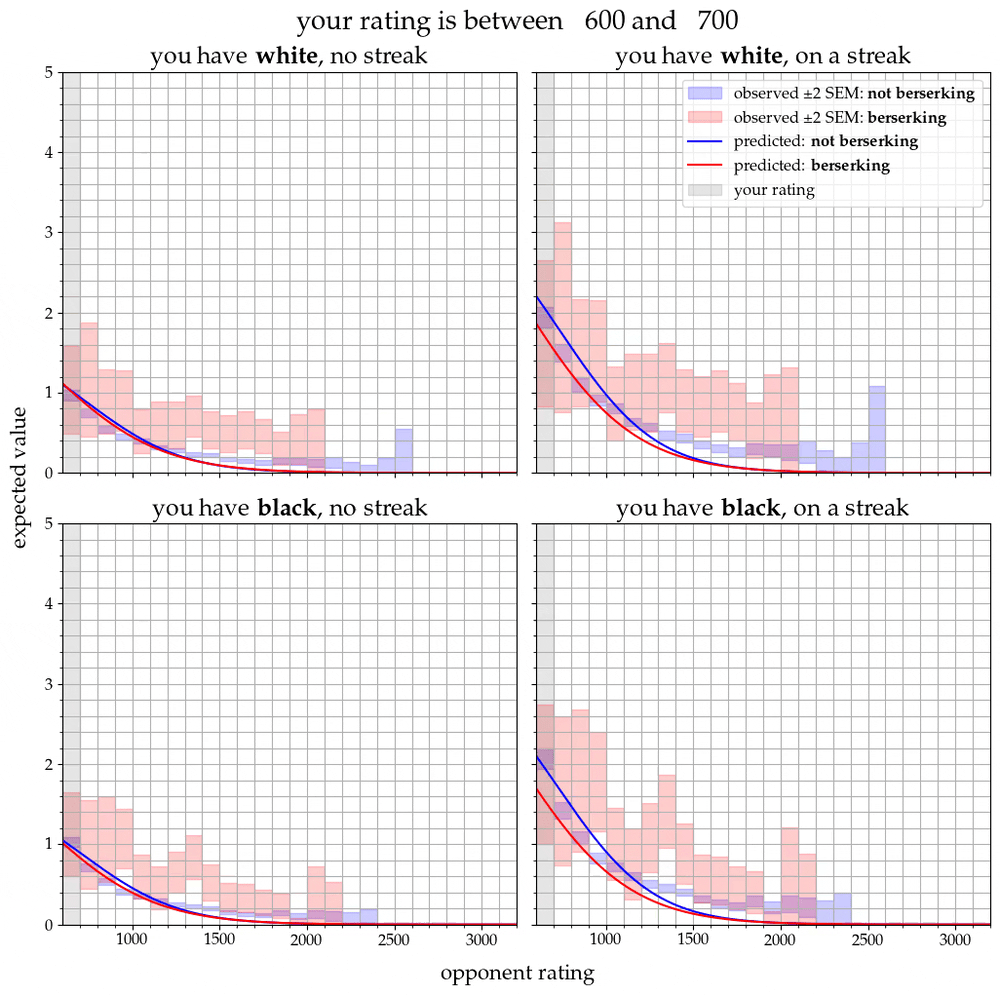

In [17]:
bytes = open(f'plots/{time}_expected_value_curves.gif', 'rb').read()
encoded_string = base64.b64encode(bytes).decode()
HTML(f'<img src="data:image/gif;base64,{encoded_string}"/>')

For completion's sake, we can also redo the two plots above, this time using the model WDL probabilities. 
### WDL model expected value of berserking vs. not berserking
We see the model generates a similar pattern to the empirical one. I have likewise clamped the colormap here to 1 and -1. 

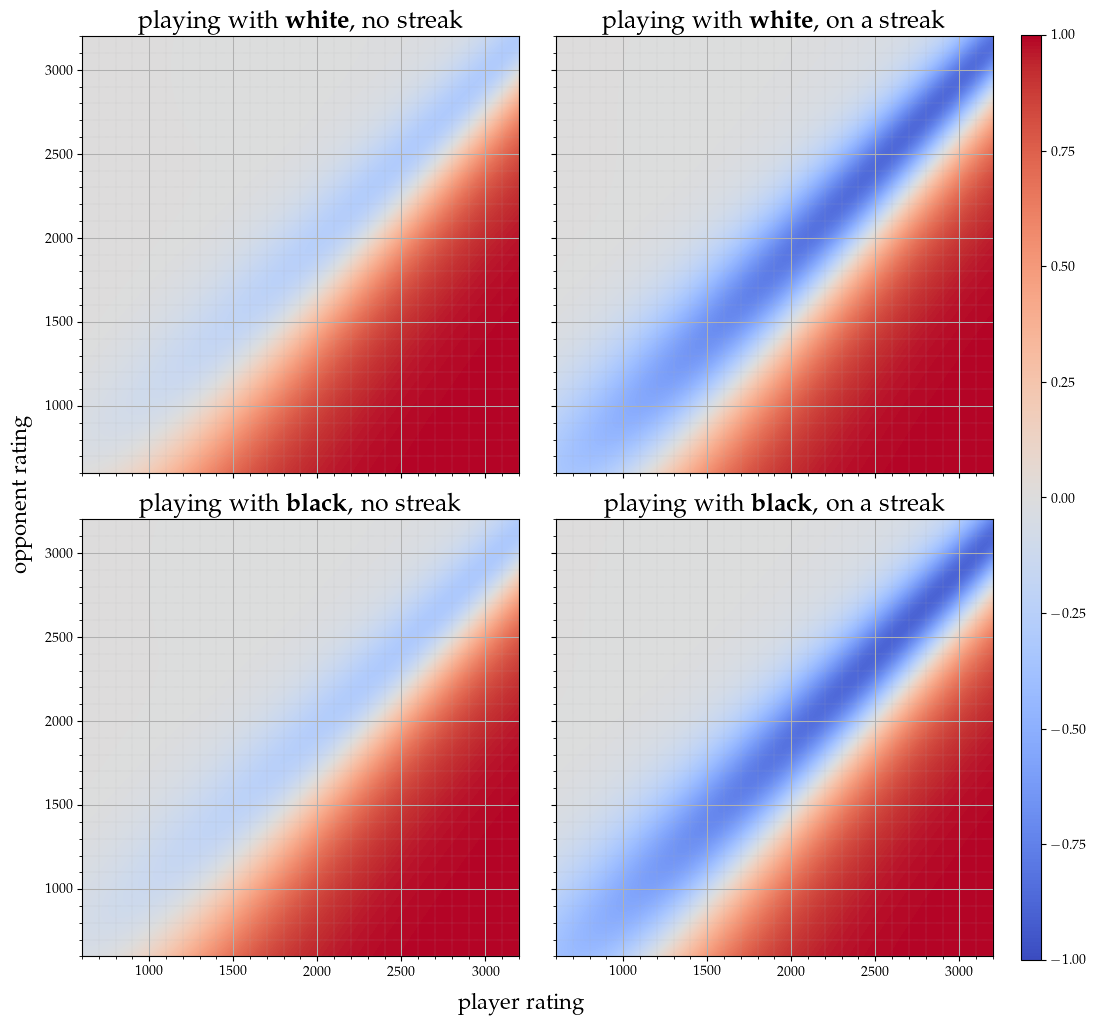

In [18]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs = axs.flatten()

titles = [
    r'playing with \textbf{white}, no streak', 
    r'playing with \textbf{white}, on a streak', 
    r'playing with \textbf{black}, no streak', 
    r'playing with \textbf{black}, on a streak'
]

wb = [1,1,0,0]
bb = [0,0,1,1]
va = [[0,1,2], [0,2,4], [2,1,0], [4,2,0]]
vb = [[0,1,3], [0,2,5], [3,1,0], [5,2,0]]
side = ['white_rating', 'white_rating', 'black_rating', 'black_rating']

for i, ax in enumerate(axs):
    a = wdl_probs[(t['white_berserked'] == 0) & (t['black_berserked'] == 0)]
    b = wdl_probs[(t['white_berserked'] == wb[i]) & (t['black_berserked'] == bb[i])]
    ea = np.dot(a, va[i])
    eb = np.dot(b, vb[i])
    d = eb - ea

    s1, s2 = np.meshgrid(ratings, ratings)
    d = d.reshape(s1.shape)
    if side[i] == 'white_rating':
        subplot = ax.pcolormesh(s2, s1, d, cmap=plt.cm.coolwarm, vmin=-1, vmax=1)
    elif side[i] == 'black_rating':
        subplot = ax.pcolormesh(s1, s2, d, cmap=plt.cm.coolwarm, vmin=-1, vmax=1)


    ax.minorticks_on()
    ax.grid(axis='both', which='major', linewidth=0.75)
    ax.grid(axis='both', which='minor', linewidth=0.25, linestyle=':')
    ax.set_aspect('equal')
    ax.set_title(titles[i], fontsize=18)

del a, b, d, ea, eb, s1, s2

fig.text(0.5, -0.01, 'player rating', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.5, 'opponent rating', ha='center', va='center', rotation='vertical', fontsize=16)
fig.tight_layout()

cb_ax = fig.add_axes([1.0, 0.035, 0.02, 0.925])
cbar = fig.colorbar(subplot, cax=cb_ax)

plt.savefig(f'plots/{time}_berserk_expected_value_difference.png')

### Policy for berserking vs. not berserking based on WDL model expected values
The model policy has smoothed out the noise of the empirical one, but otherwise generated a similar pattern. The same proviso applies here: the degree to which berserking is better than not is lost in this plot.

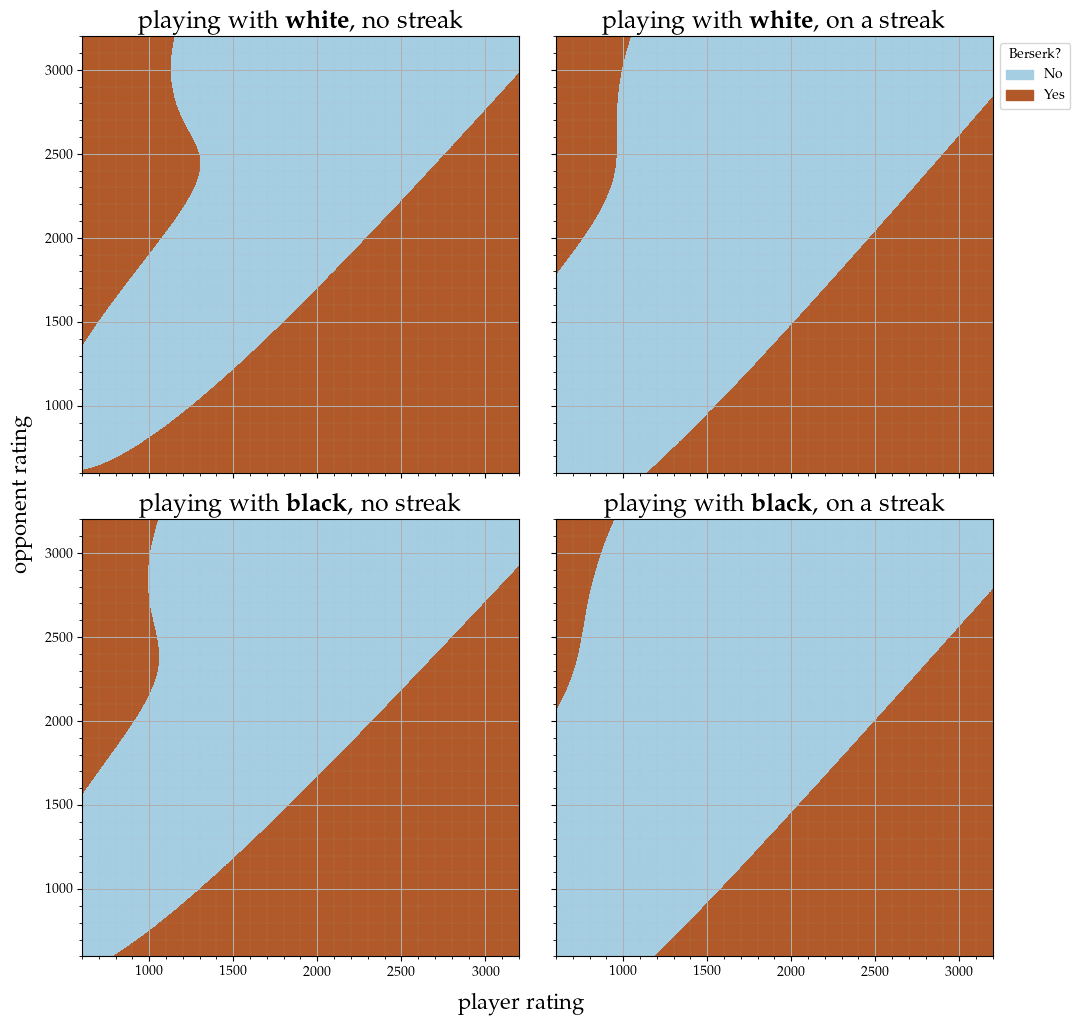

In [19]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs = axs.flatten()

titles = [
    r'playing with \textbf{white}, no streak', 
    r'playing with \textbf{white}, on a streak', 
    r'playing with \textbf{black}, no streak', 
    r'playing with \textbf{black}, on a streak'
]

wb = [1,1,0,0]
bb = [0,0,1,1]
va = [[0,1,2], [0,2,4], [2,1,0], [4,2,0]]
vb = [[0,1,3], [0,2,5], [3,1,0], [5,2,0]]
side = ['white_rating', 'white_rating', 'black_rating', 'black_rating']

for i, ax in enumerate(axs):

    a = wdl_probs[(t['white_berserked'] == 0) & (t['black_berserked'] == 0)]
    b = wdl_probs[(t['white_berserked'] == wb[i]) & (t['black_berserked'] == bb[i])]
    ea = np.dot(a, va[i])
    eb = np.dot(b, vb[i])
    d = eb - ea

    d = np.sign(d)

    s1, s2 = np.meshgrid(ratings, ratings)
    d = d.reshape(s1.shape)
    if side[i] == 'white_rating':
        s = ax.pcolormesh(s2, s1, d, cmap=cmap2, norm=norm)
    elif side[i] == 'black_rating':
        s = ax.pcolormesh(s1, s2, d, cmap=cmap2, norm=norm)

    ax.minorticks_on()
    ax.grid(axis='both', which='major', linewidth=0.75)
    ax.grid(axis='both', which='minor', linewidth=0.25, linestyle=':')
    ax.set_aspect('equal')
    ax.set_title(titles[i], fontsize=18)
    
del a, b, ea, eb, d, s1, s2

fig.text(0.5, -0.01, 'player rating', ha='center', va='center', fontsize=16)
fig.text(0.0, 0.5, 'opponent rating', ha='center', va='center', rotation='vertical', fontsize=16)
fig.tight_layout()

labels = ['No', 'Yes']
legend_color = axs[1].legend([patches.Patch(color=cmap2(i)) for i in [0, 1]], labels, bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Berserk?')

plt.savefig(f'plots/{time}_berserk_expected_value_better.png')

### Modeling the probability that your opponent berserks
It will be important below to have some model of the probability that your opponent berserks, given various factors. Unfortunately, I neglected to record some of the relevant factors when I was processing the PGNs, and other relevant factors are impossible to discern from the PGNs (e.g., if both sides berserked, which side berserked first?). Therefore, I used a crude approach in which I fit another logistic regression model to the data which predicts your opponent's probability of berserking based on your rating and what color each player has (and assuming you yourself have not decided yet whether to berserk). This fitting was done in `berserk_model_search.py`. On the plus side, the WDL model described above is certainly the most important when it comes to the generated policy recommendations below, so there is not quite so much riding on the veridicality and accuracy of this berserk model and the next model I will describe. 

In [20]:
berserk_model = joblib.load(f'pickles/{time}_berserk_model_search.pkl')
berserk_probs = berserk_model.predict_proba([[wr, br] for wr in ratings for br in ratings])

In [21]:
def opponent_berserkp(player_rating, opponent_rating, player_color, opponent_berserk):
    if player_color == Color.WHITE:
        return berserk_probs[Color.BLACK][
            np.ravel_multi_index(
                (player_rating - min_rating, opponent_rating - min_rating), 
                (len(ratings), len(ratings))
            )
        ][opponent_berserk]
    else:
        return berserk_probs[Color.WHITE][
            np.ravel_multi_index(
                (opponent_rating - min_rating, player_rating - min_rating), 
                (len(ratings), len(ratings))
            )
        ][opponent_berserk]

In [22]:
for interval in rating_interval_range:
    r = int(interval.mid)
    rl = interval.left
    rr = interval.right
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
    axs = axs.flatten()

    for i, (ax, player_color) in enumerate(zip(axs, Color)):
        g = games[(games[f'{player_color}_rating'] >= rl) & (games[f'{player_color}_rating'] < rr)]
        bp = g.groupby(pd.cut(g[f'{player_color.opposite()}_rating'], rating_interval_range)).agg(prob=(f'{player_color.opposite()}_berserked', np.mean)).to_numpy().squeeze()
        ax.plot([interval.mid for interval in rating_interval_range], bp, 'o')
        mbp = [opponent_berserkp(r, rating, player_color, Action.BERSERK) for rating in ratings]
        ax.plot(ratings, mbp, '-')

        ax.set_xlim(min_rating, max_rating)
        ax.set_ylim(0, 1)
        ax.grid('both', which='both')
        ax.minorticks_on()
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_title(f'you have {player_color}', fontsize=18)

        # if i == legend_axis: legend = ax.legend(loc='best', fontsize=12)

    ls = r'\phantom{0}' if rl < 1000 else ''
    rs = r'\phantom{0}' if rr < 1000 else ''
    fig.suptitle(fr'your rating is between {ls}{rl} and {rs}{rr}', fontsize=20)
    fig.text(0.5, -0.01, 'opponent rating', ha='center', va='center', fontsize=16)
    fig.text(-0.01, 0.5, 'opponent berserk probability', ha='center', va='center', rotation='vertical', fontsize=16)
    fig.tight_layout()

    plt.savefig(f'plots/{time}_berserk_probs_{rl:04}_{rr:04}.png')
    plt.close(fig)

In [23]:
subprocess.call([   
    'ffmpeg',
    '-hide_banner', 
    '-loglevel', 'error',
    '-f', 'image2',
    '-pattern_type', 'glob',
    '-framerate', '2', 
    '-i', f'plots/{time}_berserk_probs_*.png', 
    f'plots/{time}_berserk_probs.mp4', 
    '-y'
]);

In [24]:
# https://gif.ski/
subprocess.call([
    'gifski',
    '--quiet',
    '--fps', '2',
    '--width', '1000',
    '-o', f'plots/{time}_berserk_probs.gif', 
    f'plots/{time}_berserk_probs.mp4'
]);

Even so, we can see in this plot that the model does a tolerable job. The model predicted opponent berserk probability is the orange curve, and the blue dots are the empirical relative frequencies from the data. I didn't bother to include any measure of confidence for the empirical values in this plot. We can see the model generally does OK, except for some minor troubles at the lower end of the ratings. 


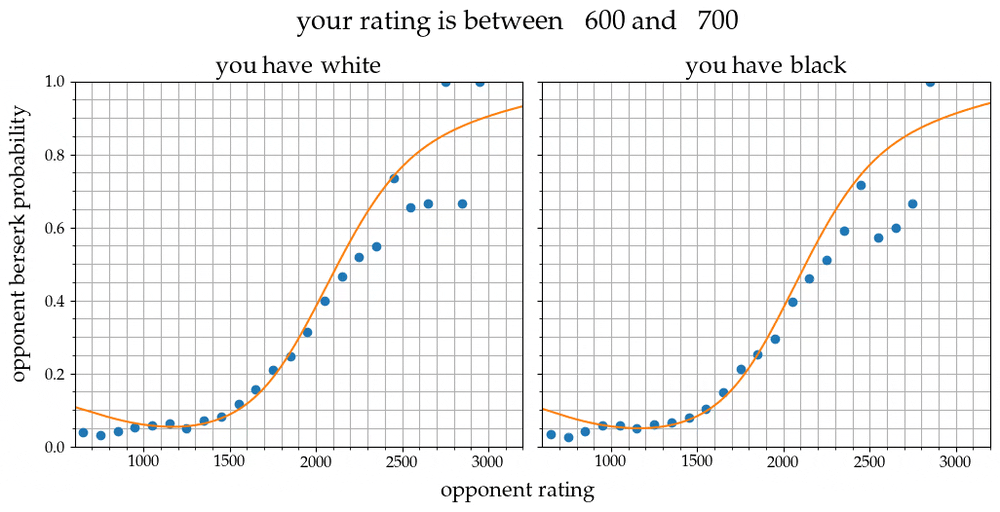

In [25]:
bytes = open(f'plots/{time}_berserk_probs.gif', 'rb').read()
encoded_string = base64.b64encode(bytes).decode()
HTML(f'<img src="data:image/gif;base64,{encoded_string}"/>')

### Modeling the probability of your opponent's rating
We also need a model of how likely you are to be matched with a player of a given rating. Again, some relevant factors here I neglected to record when processing the PGNs, so we resort again to a quick and dirty model. In this case, I consider only your own rating as a predictor variable for your opponent's. The reasoning is that arena tournament pairing works by attempting to pair you with someone close to you in terms of current tournament ranking. In the limit, all else being equal, tournament ranking should equate to relative player rating.

I first split player ratings into bins of width 100 rating points, then modeled the distributions of opponent ratings within each of these as beta distributions. Then, I fit smoothing splines to the progressions over the two beta distribution parameters (a, b) for each player rating bin. The plot below shows the data together with the model. The x-axis in each subplot is the opponent rating, while the title of each subplot is the player rating bin. We can see that the model fails to capture fully the spikes that occur in the empirical distributions for some bins, and over- or under-estimates the tails of some others. Still, for my quick-and-dirty purposes, it seems fine enough.

In [26]:
matchups = pd.concat([games[['white_rating', 'black_rating']], games[['black_rating', 'white_rating']]])
matchups.columns = ['player_rating', 'opponent_rating']

In [27]:
from scipy.stats import beta
eps = 1e-9
smin = min_rating - eps
smax = max_rating + 1 + eps
step = 100
fits = []
steps = np.arange(min_rating, max_rating, step)
for r in steps:
    opponent_ratings = matchups['opponent_rating'][(matchups['player_rating'] >= r) & (matchups['player_rating'] < r + step)]
    fits.append([*beta.fit(opponent_ratings, floc=smin, fscale=smax - smin)])
fits = np.array(fits)

In [28]:
from scipy.interpolate import UnivariateSpline

a_spline = UnivariateSpline(steps, fits[:,0], k=3, s = 1)
b_spline = UnivariateSpline(steps, fits[:,1], k=3, s = 1)

fig, (axa, axb) = plt.subplots(2, 1, sharex=True)

axa.plot(steps, fits[:,0], 'o')
axa.plot(steps, a_spline(steps), '-')
axa.set_xlim(min_rating-25, max_rating-step+25)
axa.set_title('a')
axb.plot(steps, fits[:,1], 'o')
axb.plot(steps, b_spline(steps), '-')
axb.set_title('b');

plt.savefig(f'plots/{time}_opponent_rating_prob_model_beta_params_splines.png')
plt.close(fig)

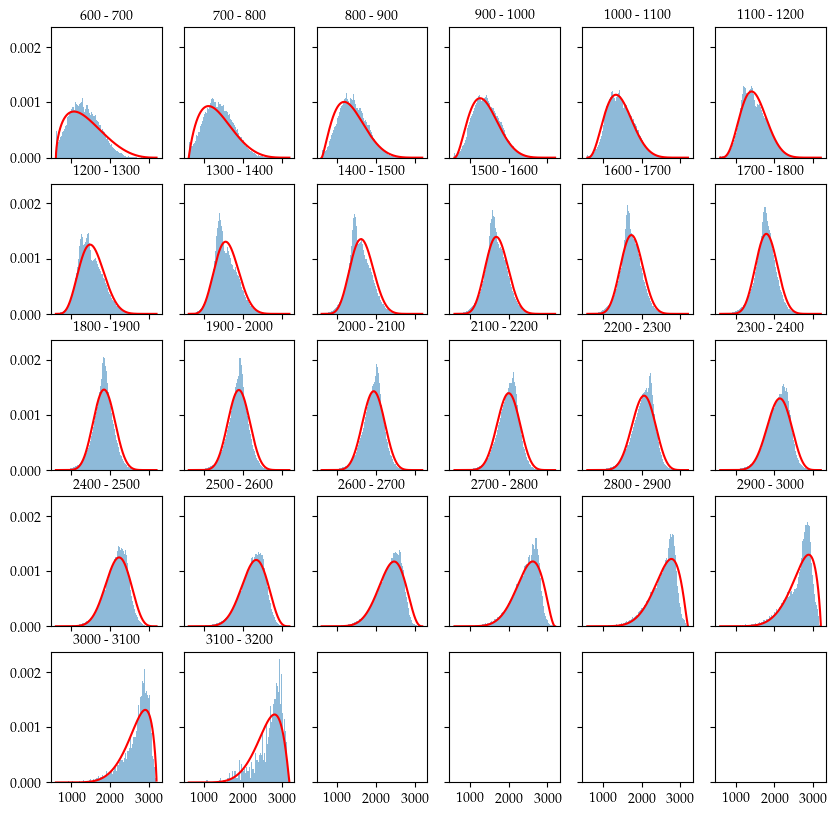

In [29]:
from matplotlib.ticker import FuncFormatter
n = len(steps)
fig, axs = plt.subplots(int(np.ceil(n/6)), 6, figsize=(10,10), sharex=True, sharey=True)
axs = axs.flatten()
x = ratings
for r, ax in zip(steps, axs):
    opponent_ratings = matchups['opponent_rating'][(matchups['player_rating'] >= r) & (matchups['player_rating'] < r + step)]
    ax.hist(opponent_ratings, bins=100, density=True, alpha=0.5)
    ax.plot(x, beta.pdf(x, a_spline(r+step/2), b_spline(r+step/2), smin, smax - smin), color='r')
    ax.set_title('{} - {}'.format(r, r + step), fontsize=10)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(round(x/step)*step)))

plt.savefig(f'plots/{time}_opponent_rating_prob_model_vs_data.png')

Now we can put all of these models together.

## Modeling arena tournament play as a Markov decision process
So far we only looked at whether to berserk when considering one game in isolation. But what we are really interested in is maximizing our points over the course of a whole tournament. To model this, we need to consider how our decision to berserk in one game affects our point-earning prospects in following games. For example, if you are currently on a streak, then losing a game means you'll lose the ability to earn double points on wins for at least 2 games. Even if the expected value of berserking on the currrent game (when considered in isolation) is higher than the expected value of not berserking, this might be outweighed by the potential loss of points in future games, so that the best decision is in fact not to berserk. How do we model this? 

It turns out that playing in an arena tournament can essentially be viewed as a [Markov decision process](https://en.wikipedia.org/wiki/Markov_decision_process) (MDP). The figure below demonstrates a simplified model. You are always in one of 3 states corresponding to your current win streak: the nodes 0, 1, or 2+. There are two possible actions in each state: to berserk (red lines/nodes) or not (blue lines/nodes). And for each state-action pair, there are two possible results: win or lose (assume for simplicity that draws aren't possible in this example). Each of these possible results has a reward associated with it: the points you earn (green numbers). Finally, each transition to a new state given the current state-action pair has some (possibly 0) probability of occurring (only the transitions with non-zero probability are depicted in this example).

![simple MDP for arena tournament play without draws](images/simple_mdp_no_draws.png "simple MDP for arena tournament play without draws")

Once you have formulated a given problem as an MDP, there are standard techniques to determine the optimal policy that maximizes the total reward over time. In our case, we just need to go beyond this toy model by adding some more dimensionality to the state space. Specifically, we consider that each possible tuple of `(your win streak, your color, opponent rating, opponent berserked)` is a state. (To balance between keeping the problem discrete and not having an unmanageable combinatorial explosion in the number of states, we quantize ratings to bins of width 10.) Also, of course, we include the possibility of draws. All that remains is to determine the probability of each state-action-state transition. This is where the models we created in the above sections come in. The WDL model predicts, given your current state, what your streak will be next game. The opponent berserk model predicts whether your opponent will berserk in the next game. The opponent rating model predicts what your opponent's rating will be in the next game. Finally, we assume you are equally likely to have white or black in your next game. 

In this setup I have cobbled together, I have made various assumptions of varying questionability so as to make the modeling tractable, or to make the best of the data I had:
- I assume a tournament of infinite duration. In actuality, standard bullet tournaments are 30 minutes, blitz are 1 hour, Titled Arenas are 2 hours, and Blitz Titled Arenas are 3 hours. 
- I assume all games take the same amount of time. In particular, I assume games in which neither side berserked take no longer than games in which one or both sides berserked. It would have been possible to record total game time for each game when processing the PGNs, but I didn't think to do so at the time. However, a casual inspection of the total games played by competitors in a handful of Titled Arenas and Blitz Titled Arenas showed that this assumption is perhaps not so dreadfully inaccurate as it might initially seem.
- I assume the tournament has an infinite number of players. This is so that the assumptions behind the model predicting your opponent's rating work out.
- I assume no other competitor is learning or has learned an optimal policy; they all are assumed to act according the models fit to the data above.

Had I had these ideas clearly in mind when I initially set out to collect this data, I would have removed these assumptions, and considered more detailed, continuous finite-time MDPs where the tournament duration, competitors' rating distribution, competitors' moment-to-moment rankings/points, competitors' individual strategies, and other factors all come into play. In that case, multi-agent reinforcement learning and (evolutionary) game theory techniques could be applied, which would provide a much richer and more accurate answer to this overall question. 

I did not do that though, so in conclusion, here are the results for what I did do:

In [30]:
rstep = 10 # n.b. this step doesn't have to be the same as the step used in the opponent rating prob model above
opponent_ratings = np.arange(min_rating, max_rating, rstep)
player_ratings = np.arange(min_rating, max_rating, rstep)

# takes linear index of state in array of all states and returns (streak, color, opponent_rating, opponent_berserked) tuple
# the linear order is ascending order sorted with opponent_rating varying within color varying within streak 
def ind2tup(i): 
    s_i, c_i, o_i, a_i = np.unravel_index(i, (len(streaks), len(colors), len(opponent_ratings), len(actions)))
    return (streaks[s_i], colors[c_i], opponent_ratings[o_i], actions[a_i])

def wdl(color, player_rating, opponent_rating, opponent_berserk, berserk):
    if color == Color.WHITE:
        # recall the model target vector indices are 0 = black win, 1 = draw, 2 = white win
        lossp, drawp, winp = wdl_probs[ 
            np.ravel_multi_index( # cf. the construction of wdl_probs above
                (player_rating - min_rating, opponent_rating - min_rating, berserk, opponent_berserk), 
                (len(ratings), len(ratings), len(actions), len(actions))
            )
        ]
    else:
        winp, drawp, lossp = wdl_probs[
            np.ravel_multi_index(
                (opponent_rating - min_rating, player_rating - min_rating, opponent_berserk, berserk), 
                (len(ratings), len(ratings), len(actions), len(actions))
            )
        ]
    return winp, drawp, lossp

colorp = 0.5 # assume you have equal chances of getting black or white in the next game (I assume this is true?) 

opponent_rating_cdf = lambda player_rating, opponent_rating: beta.cdf(
    opponent_rating, a_spline(player_rating), b_spline(player_rating), loc=smin, scale=smax - smin
)

opponent_rating_table = np.zeros((len(player_ratings), len(opponent_ratings)))
for p, player_rating in enumerate(player_ratings):
    for o, opponent_rating in enumerate(opponent_ratings):
        opponent_rating_table[p, o] = opponent_rating_cdf(player_rating, opponent_rating + rstep) - opponent_rating_cdf(player_rating, opponent_rating)

def opponent_ratingp(player_rating, opponent_rating):
    return opponent_rating_table[(player_rating - min_rating) // rstep, (opponent_rating - min_rating) // rstep]


draw_reward = lambda streak: 1 + (streak == Streak.TWO_PLUS)
win_reward = lambda streak, action: 2 * (1 + (streak == Streak.TWO_PLUS)) + (action == Action.BERSERK)

n_states = len(streaks) * len(colors) * len(opponent_ratings) * len(actions)

n_streak_states = int(n_states / len(streaks))

possible_states = np.zeros((len(streaks), len(results), n_streak_states), dtype=int)
possible_states[Streak.ZERO, Result.LOSS_OR_DRAW] = possible_states[Streak.ONE, Result.LOSS_OR_DRAW] = possible_states[Streak.TWO_PLUS, Result.LOSS_OR_DRAW] = np.arange(0, n_streak_states)
possible_states[Streak.ZERO, Result.WIN] = np.arange(n_streak_states, 2 * n_streak_states)
possible_states[Streak.ONE, Result.WIN] = possible_states[Streak.TWO_PLUS, Result.WIN] = np.arange(2 * n_streak_states, n_states)

threshold = 1e-1
gamma = 1 - 1e-1


In [31]:
# precompute s-a-s' transition probabilities p and expected rewards r, then store p * r and p * gamma
# the heavy part of the value update equation is p * (r + gamma * v(s')) = p * r + p * gamma * v(s') = pr + pg * v(s')
def precompute_tables(player_rating):
    pr = np.zeros((n_states, len(actions), n_states))
    pg = np.zeros((n_states, len(actions), n_states))
    for i in range(n_states):
        streak, color, opponent_rating, opponent_berserk = ind2tup(i)
        for a, action in enumerate(actions):
            winp, drawp, lossp = wdl(color, player_rating, opponent_rating, opponent_berserk, action)
            for j in possible_states[streak, Result.LOSS_OR_DRAW]:
                _, next_color, next_opponent_rating, next_opponent_berserk = ind2tup(j)
                next_opponent_ratingp = opponent_ratingp(player_rating, next_opponent_rating)
                next_opponent_berserkp = opponent_berserkp(player_rating, next_opponent_rating, next_color, next_opponent_berserk)
                transition_prob = (lossp + drawp) * colorp * next_opponent_ratingp * next_opponent_berserkp 
                expected_reward = (0 * lossp + draw_reward(streak) * drawp) / (lossp + drawp)
                pr[i, a, j] = transition_prob * expected_reward
                pg[i, a, j] = transition_prob * gamma
            for j in possible_states[streak, Result.WIN]:
                _, next_color, next_opponent_rating, next_opponent_berserk = ind2tup(j)
                next_opponent_ratingp = opponent_ratingp(player_rating, next_opponent_rating)
                next_opponent_berserkp = opponent_berserkp(player_rating, next_opponent_rating, next_color, next_opponent_berserk)
                transition_prob = winp * colorp * next_opponent_ratingp * next_opponent_berserkp
                expected_reward = win_reward(streak, action)
                pr[i, a, j] = transition_prob * expected_reward
                pg[i, a, j] = transition_prob * gamma
    return pr, pg

In [32]:
def value_iteration(player_rating):
    pr, pg = precompute_tables(player_rating)
    values = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=int)
    values_by_action = np.zeros((n_states, len(actions)))
    delta = 1e9
    iteration = 0

    while delta > threshold:
        delta = 0
        for i, value in enumerate(values):
            max_value = 0
            for a, action in enumerate(actions): 
                v = np.sum(pr[i,a] + pg[i,a] * values)
                max_value = max(max_value, v)
            values[i] = max_value
            delta = max(delta, abs(value - values[i]))
        # print(f'rating {player_rating} iteration {iteration} delta {delta}')
        iteration += 1

    for i in range(len(policy)):
        max_value = 0
        for a, action in enumerate(actions):
            v = np.sum(pr[i,a] + pg[i,a] * values)
            values_by_action[i][a] = v
            if v > max_value:
                max_value = v
                policy[i] = action

    return values, policy, values_by_action

if os.path.isfile(f'pickles/{time}_value_iteration_{rstep}_rating_step.pkl'):
    values, policy, values_by_action = joblib.load(f'pickles/{time}_value_iteration_{rstep}_rating_step.pkl')
else:
    from joblib import Parallel, delayed
    import multiprocessing
    num_cores = multiprocessing.cpu_count()
    values, policy, values_by_action = zip(*Parallel(n_jobs=num_cores, verbose=50)(delayed(value_iteration)(player_rating) for player_rating in player_ratings))
    values, policy, values_by_action = np.asarray(values), np.asarray(policy), np.asarray(values_by_action)
    joblib.dump((values, policy, values_by_action), f'pickles/{time}_value_iteration_{rstep}_rating_step.pkl')

### MDP optimal policy for berserking vs. not berserking
We recapitulate the policy plots from earlier, now using the optimal policy found for the MDP. 

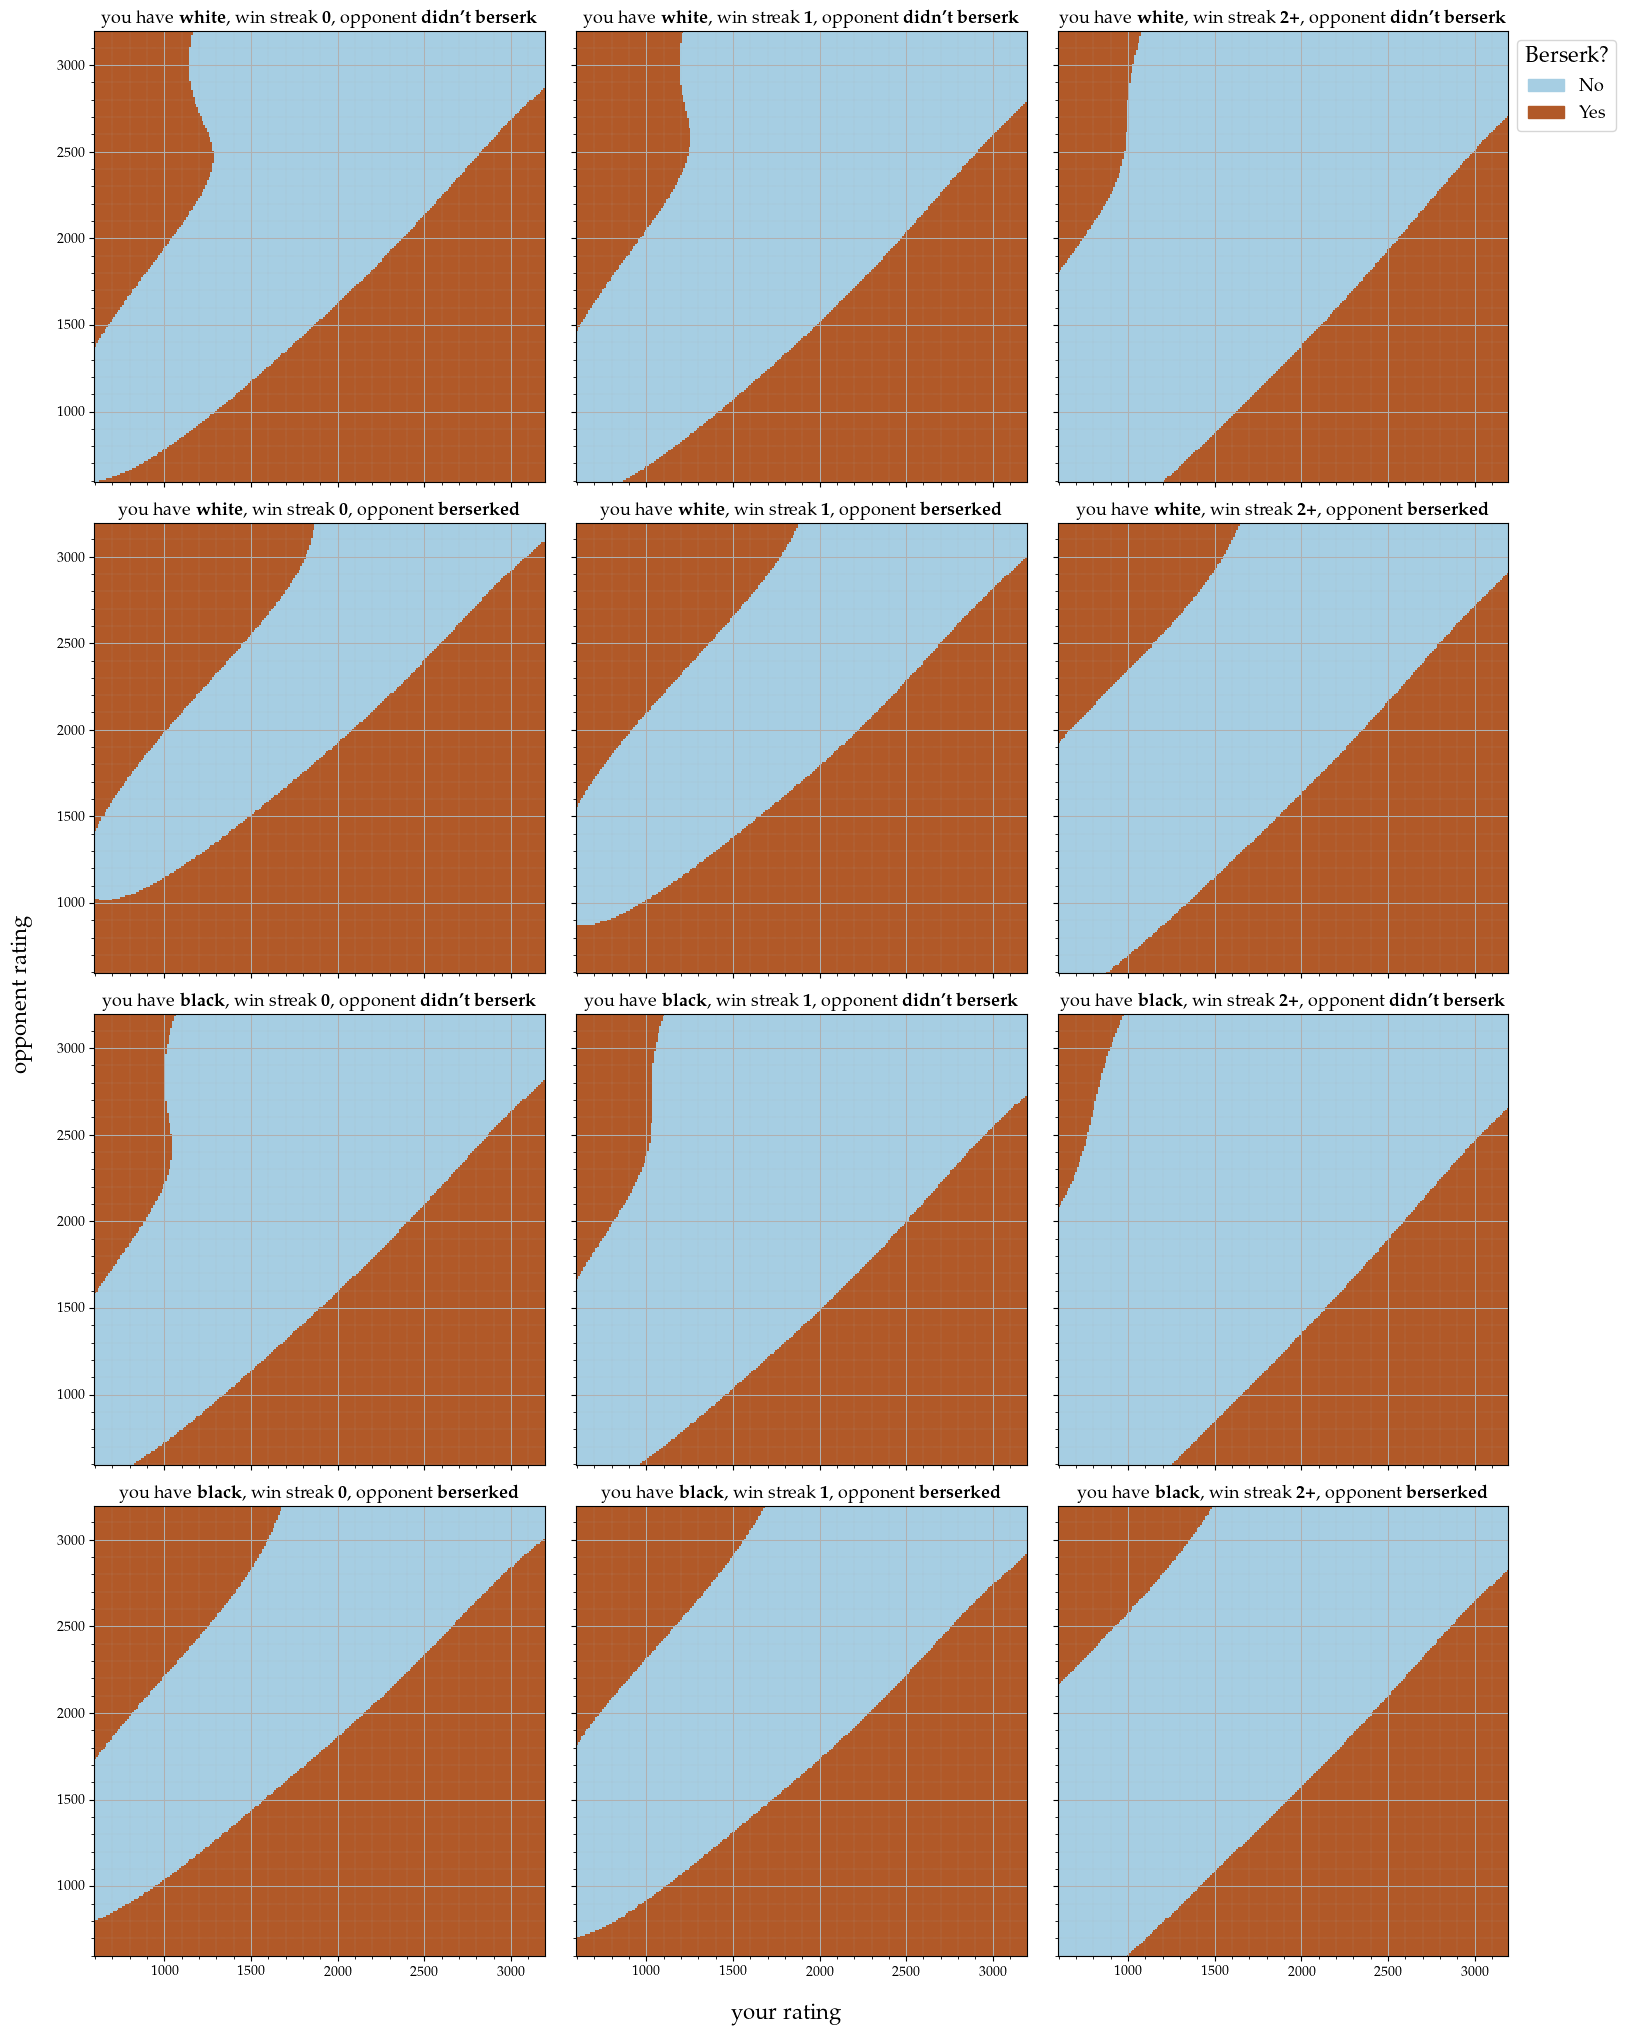

In [33]:
fig, axs = plt.subplots(len(colors) * len(actions), len(streaks), sharex=True, sharey=True, figsize=(15, 20))

for k, (color, opponent_berserk) in enumerate(itertools.product(Color, Action)):
    for s, streak in enumerate(Streak):

        ax = axs[k, s]

        ind = [i for i in range(n_states) if ind2tup(i)[0] == streak and ind2tup(i)[1] == color and ind2tup(i)[3] == opponent_berserk]

        p = policy[:, ind]

        r1, r2 = np.meshgrid(player_ratings, player_ratings)
        ax.pcolormesh(r2, r1, p, cmap=cmap2, norm=norm)

        ax.minorticks_on()
        ax.grid(axis='both', which='major', linewidth=0.75)
        ax.grid(axis='both', which='minor', linewidth=0.25, linestyle=':')
        ax.set_aspect('equal')
        b = 'didn\'t berserk' if opponent_berserk == Action.NO_BERSERK else 'berserked'
        ax.set_title(fr'you have \textbf{{{color}}}, win streak \textbf{{{streak}}}, opponent \textbf{{{b}}}', fontsize=13)
    

fig.text(0.5, -0.01, 'your rating', ha='center', va='center', fontsize=16)
fig.text(-0.01, 0.5, 'opponent rating', ha='center', va='center', rotation='vertical', fontsize=16)
fig.tight_layout()

labels = ['No', 'Yes']
legend = axs[0][2].legend([patches.Patch(color=cmap2(i)) for i in [0, 1]], labels, bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Berserk?', title_fontsize=16, fontsize=13)

plt.savefig(f'plots/{time}_berserk_better_mdp.png')

### MDP values for berserking vs. not berserking
Similarly, we can look at the value of berserking vs. not berserking, as calculated in the solution to the MDP. Note that these values aren't exactly the same as the expected values in earlier plots. These values don't directly correspond tournament points, since they depend on the temporal discounting parameter used in solving the MDP. 

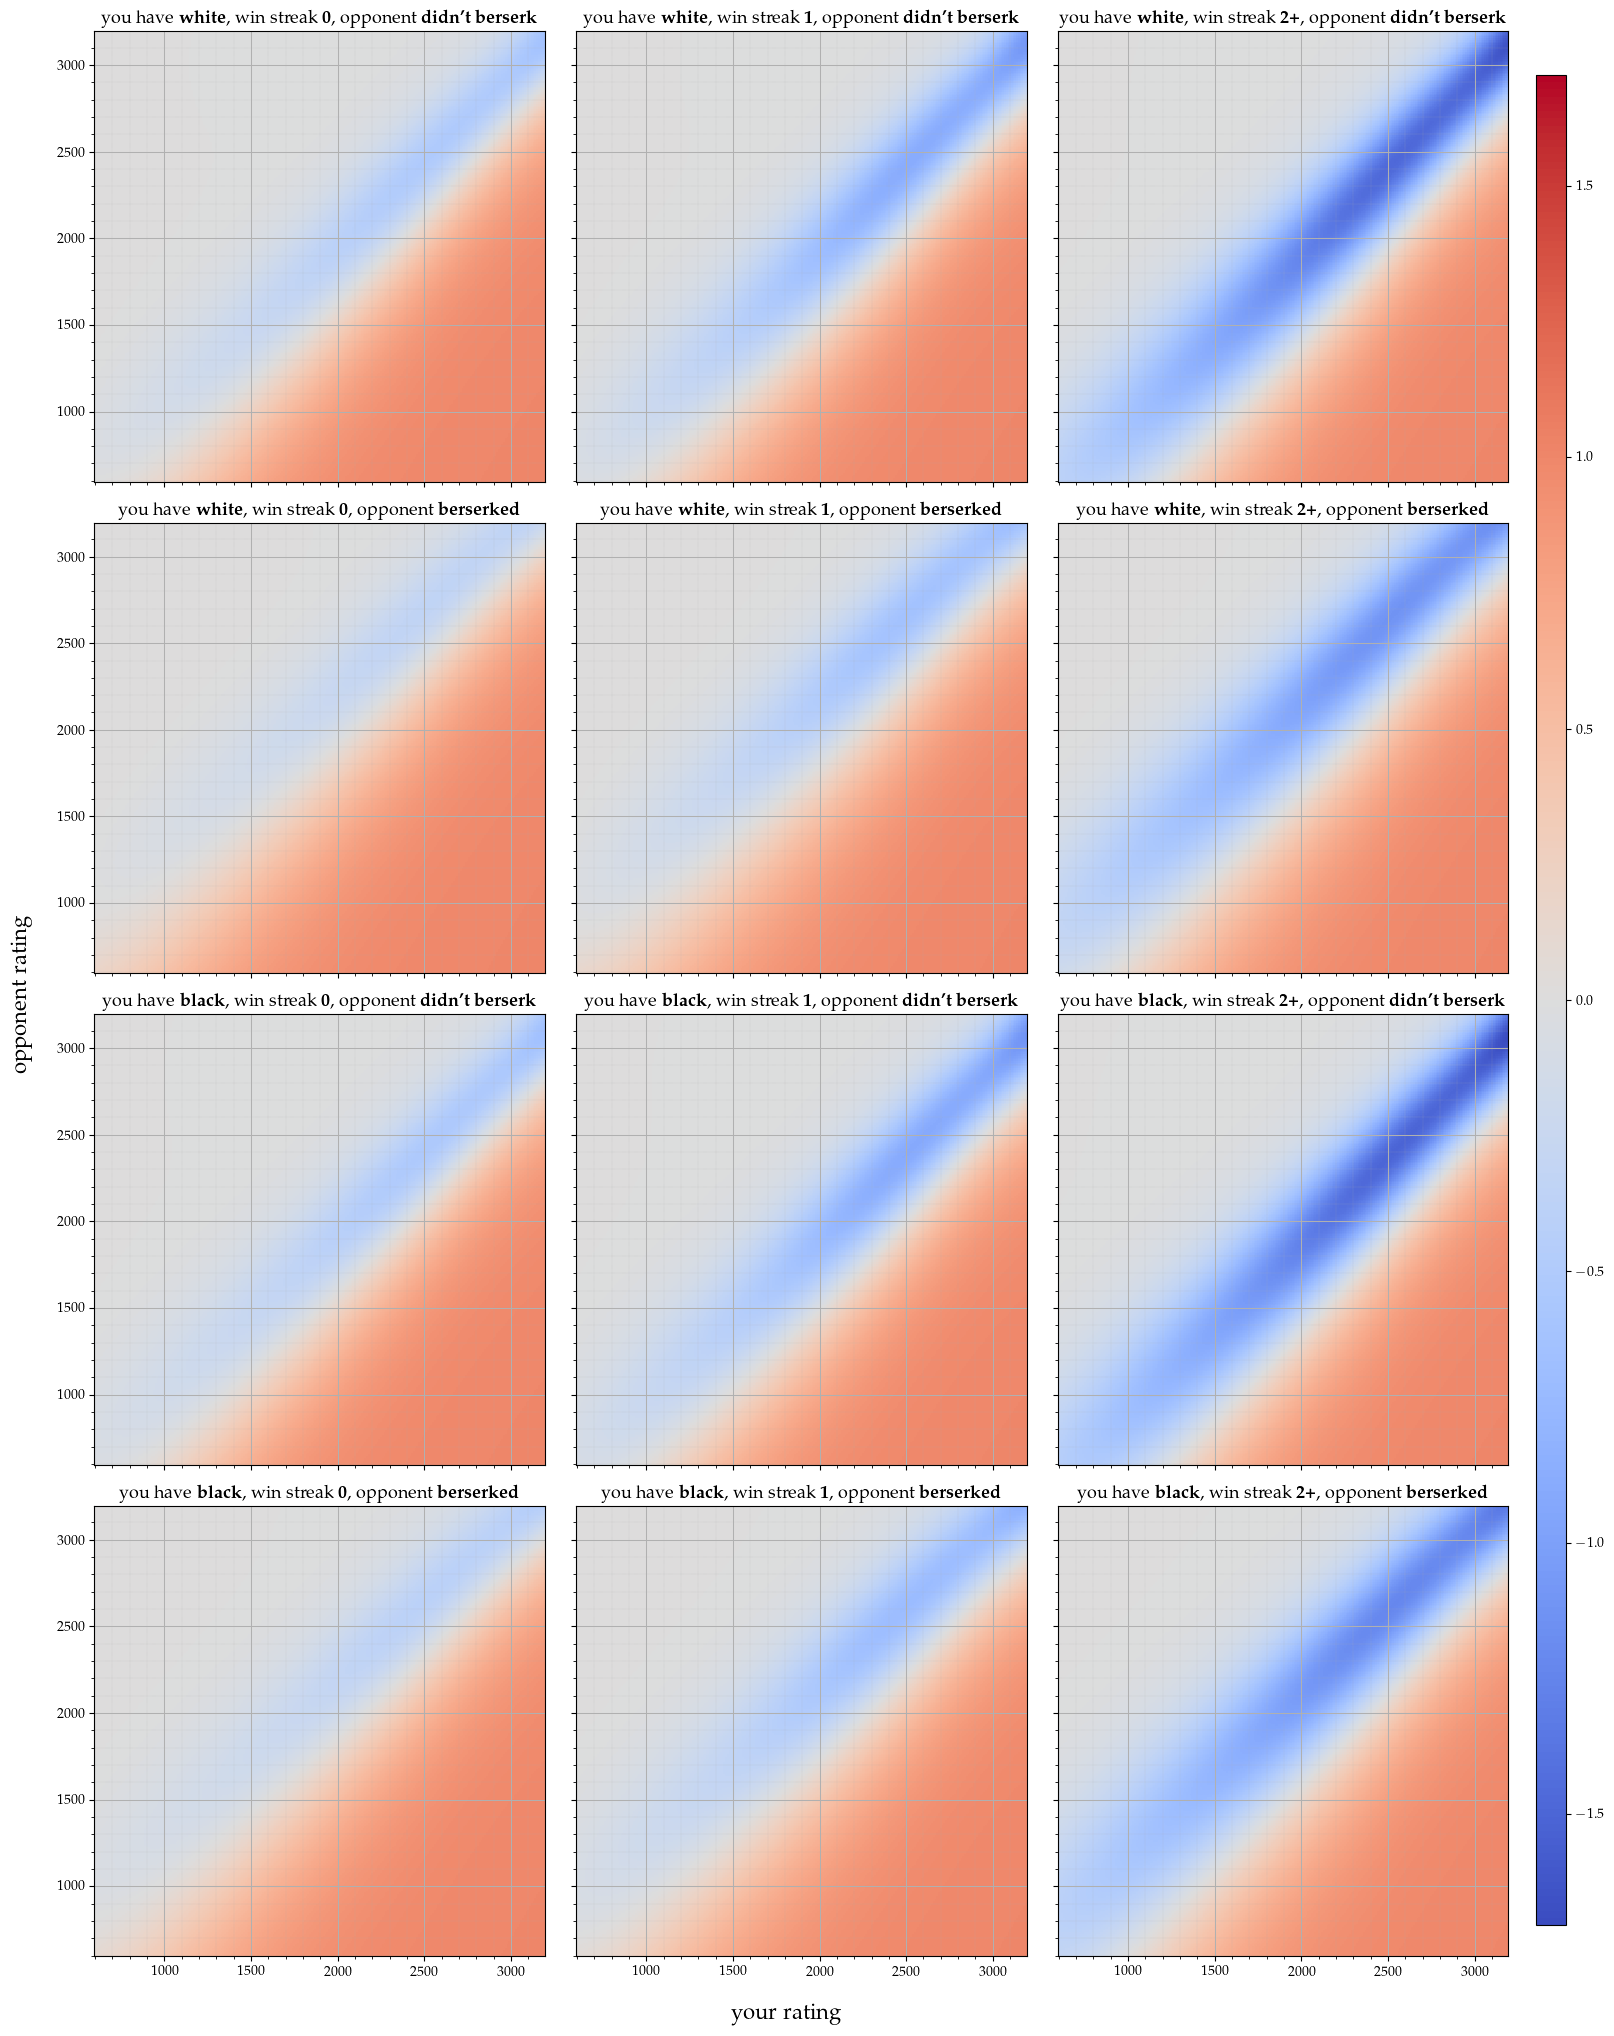

In [34]:
fig, axs = plt.subplots(len(colors) * len(actions), len(streaks), sharex=True, sharey=True, figsize=(15, 20))

d = values_by_action[:, :, Action.BERSERK] - values_by_action[:, :, Action.NO_BERSERK]
vmax = max(np.abs(np.max(d)), np.abs(np.min(d)))
vmin = -vmax

for k, (color, opponent_berserk) in enumerate(itertools.product(Color, Action)):
    for s, streak in enumerate(Streak):
        ax = axs[k, s]

        ind = [i for i in range(n_states) if ind2tup(i)[0] == streak and ind2tup(i)[1] == color and ind2tup(i)[3] == opponent_berserk]

        r1, r2 = np.meshgrid(player_ratings, player_ratings)
        subplot = ax.pcolormesh(r2, r1, d[:,ind], cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)

        ax.minorticks_on()
        ax.grid(axis='both', which='major', linewidth=0.75)
        ax.grid(axis='both', which='minor', linewidth=0.25, linestyle=':')
        ax.set_aspect('equal')
        b = 'didn\'t berserk' if opponent_berserk == Action.NO_BERSERK else 'berserked'
        ax.set_title(fr'you have \textbf{{{color}}}, win streak \textbf{{{streak}}}, opponent \textbf{{{b}}}', fontsize=13)

fig.text(0.5, -0.01, 'your rating', ha='center', va='center', fontsize=16)
fig.text(-0.01, 0.5, 'opponent rating', ha='center', va='center', rotation='vertical', fontsize=16)
fig.tight_layout()

cb_ax = fig.add_axes([1.0, 0.035, 0.02, 0.925])
cbar = fig.colorbar(subplot, cax=cb_ax)

plt.savefig(f'plots/{time}_value_difference_mdp.png')